In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os, sys

In [2]:
train = "../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train"
val = "../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val"
test = "../input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test"

In [4]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 2142 files belonging to 2 classes.


2022-07-28 17:18:32.333566: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [5]:
# Visualizing data
def visualize_random_images(dataset_type, label_type):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train if dataset_type=="train" else test
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

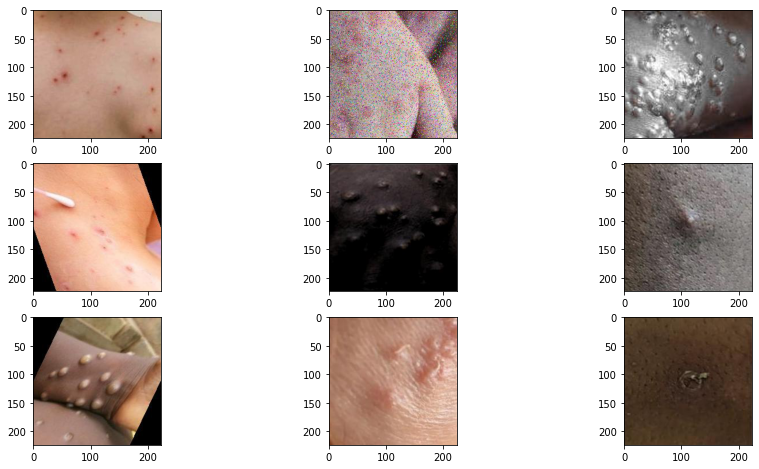

In [8]:
visualize_random_images("train", "Monkeypox")

In [9]:
def plot_loss_curves(history):
    
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [10]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

43950080/43941136 [==============================] - 7s 0us/step


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [13]:
history = model.fit(train_data,
                       epochs=20,
                       validation_data=val_data)

Epoch 1/20


2022-07-28 17:46:51.245838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


67/67 [==============================] - 119s 2s/step - loss: 0.9899 - accuracy: 0.8263 - val_loss: 0.7306 - val_accuracy: 0.7952
Epoch 2/20
67/67 [==============================] - 107s 2s/step - loss: 0.3758 - accuracy: 0.9248 - val_loss: 0.6523 - val_accuracy: 0.8833
Epoch 3/20
67/67 [==============================] - 102s 2s/step - loss: 0.2008 - accuracy: 0.9552 - val_loss: 0.7101 - val_accuracy: 0.8810
Epoch 4/20
67/67 [==============================] - 102s 2s/step - loss: 0.2107 - accuracy: 0.9570 - val_loss: 0.8518 - val_accuracy: 0.8571
Epoch 5/20
67/67 [==============================] - 102s 2s/step - loss: 0.1769 - accuracy: 0.9678 - val_loss: 0.7902 - val_accuracy: 0.8571
Epoch 6/20
67/67 [==============================] - 101s 2s/step - loss: 0.1045 - accuracy: 0.9762 - val_loss: 1.5476 - val_accuracy: 0.8548
Epoch 7/20
67/67 [==============================] - 103s 2s/step - loss: 0.1166 - accuracy: 0.9748 - val_loss: 1.3029 - val_accuracy: 0.8714
Epoch 8/20
67/67 [======

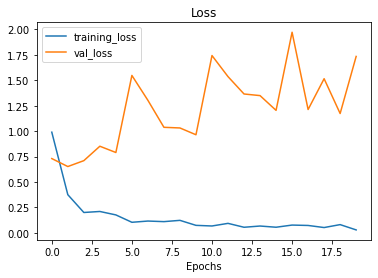

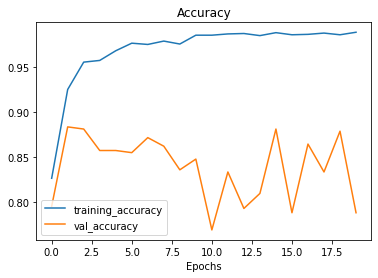

In [14]:
plot_loss_curves(history)

In [15]:
model.evaluate(test_data)

2/2 [==============================] - 2s 567ms/step - loss: 1.6968 - accuracy: 0.8889


[1.69675612449646, 0.8888888955116272]

In [16]:
y_pred = tf.math.round(model.predict(test_data))
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

In [17]:
accuracy_score(y_true, y_pred)

0.8888888888888888

In [18]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.89      0.85      0.87        20
      Others       0.88      0.92      0.90        25

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



In [23]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model_1 = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [24]:
for layer in base_model_1.layers:
    layer.trainable = False

In [25]:
x = layers.Flatten()(base_model_1.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.models.Model(base_model_1.input, x)

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [26]:
history_1 = model_1.fit(train_data,
                       epochs=10,
                       validation_data=val_data)

Epoch 1/10
67/67 [==============================] - 142s 2s/step - loss: 124.3968 - accuracy: 0.5980 - val_loss: 5.5498 - val_accuracy: 0.6738
Epoch 2/10
67/67 [==============================] - 134s 2s/step - loss: 1.0776 - accuracy: 0.7120 - val_loss: 0.5920 - val_accuracy: 0.6952
Epoch 3/10
67/67 [==============================] - 134s 2s/step - loss: 0.5110 - accuracy: 0.7372 - val_loss: 0.6553 - val_accuracy: 0.6333
Epoch 4/10
67/67 [==============================] - 134s 2s/step - loss: 0.4551 - accuracy: 0.7824 - val_loss: 0.8124 - val_accuracy: 0.4762
Epoch 5/10
67/67 [==============================] - 135s 2s/step - loss: 0.4211 - accuracy: 0.7960 - val_loss: 0.6191 - val_accuracy: 0.6762
Epoch 6/10
67/67 [==============================] - 135s 2s/step - loss: 0.3753 - accuracy: 0.8249 - val_loss: 0.8456 - val_accuracy: 0.5714
Epoch 7/10
67/67 [==============================] - 134s 2s/step - loss: 0.3559 - accuracy: 0.8357 - val_loss: 0.8296 - val_accuracy: 0.5690
Epoch 8/10


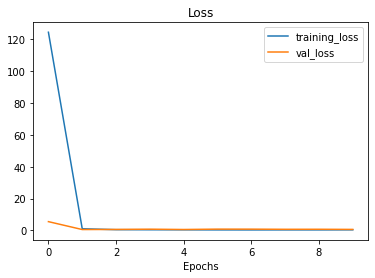

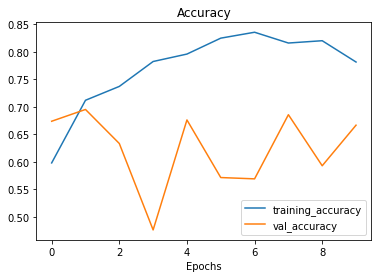

In [27]:
plot_loss_curves(history_1)

In [28]:
model_1.evaluate(test_data)

2/2 [==============================] - 2s 701ms/step - loss: 0.6662 - accuracy: 0.7556


[0.6661986708641052, 0.7555555701255798]

In [43]:
y_pred_1 = tf.math.round(model_1.predict(test_data))
y_true_1 = []
for images, labels in test_data.unbatch():
  y_true_1.append(labels.numpy())

In [45]:
accuracy_score(y_true_1, y_pred_1)

0.7555555555555555

In [46]:
print(classification_report(y_true_1, y_pred_1, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.76      0.65      0.70        20
      Others       0.75      0.84      0.79        25

    accuracy                           0.76        45
   macro avg       0.76      0.74      0.75        45
weighted avg       0.76      0.76      0.75        45



In [47]:
from tensorflow.keras.applications import ResNet50

base_model_2 = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

94781440/94765736 [==============================] - 2s 0us/step


In [51]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model_2(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model_2 = Model(inputs, outputs)

In [52]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [53]:
history_2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data)

Epoch 1/10
67/67 [==============================] - 193s 3s/step - loss: 2.5524 - accuracy: 0.7148 - val_loss: 1.6256 - val_accuracy: 0.6643
Epoch 2/10
67/67 [==============================] - 183s 3s/step - loss: 1.0936 - accuracy: 0.8305 - val_loss: 1.3910 - val_accuracy: 0.6786
Epoch 3/10
67/67 [==============================] - 183s 3s/step - loss: 0.5731 - accuracy: 0.8800 - val_loss: 0.7759 - val_accuracy: 0.7167
Epoch 4/10
67/67 [==============================] - 183s 3s/step - loss: 0.4222 - accuracy: 0.9080 - val_loss: 0.9421 - val_accuracy: 0.7048
Epoch 5/10
67/67 [==============================] - 182s 3s/step - loss: 0.2932 - accuracy: 0.9197 - val_loss: 0.9034 - val_accuracy: 0.6833
Epoch 6/10
67/67 [==============================] - 183s 3s/step - loss: 0.2229 - accuracy: 0.9328 - val_loss: 0.9521 - val_accuracy: 0.6690
Epoch 7/10
67/67 [==============================] - 182s 3s/step - loss: 0.2174 - accuracy: 0.9430 - val_loss: 1.1736 - val_accuracy: 0.6619
Epoch 8/10
67

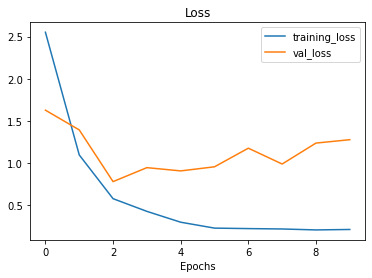

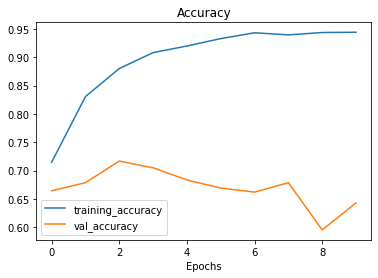

In [54]:
plot_loss_curves(history_2)

In [55]:
model_2.evaluate(test_data)

2/2 [==============================] - 3s 939ms/step - loss: 0.7440 - accuracy: 0.7778


[0.7440351843833923, 0.7777777910232544]

In [56]:
y_pred_2 = tf.math.round(model_2.predict(test_data))
y_true_2 = []
for images, labels in test_data.unbatch():
  y_true_2.append(labels.numpy())

In [57]:
accuracy_score(y_true_2, y_pred_2)

0.7777777777777778

In [58]:
print(classification_report(y_true_2, y_pred_2, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.69      0.90      0.78        20
      Others       0.89      0.68      0.77        25

    accuracy                           0.78        45
   macro avg       0.79      0.79      0.78        45
weighted avg       0.80      0.78      0.78        45

